# Exercise 15: a noisy detector

***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)
3. Estimate the error on your measurement.


---

In [31]:
import numpy as np
import pylab as plt
from sklearn.decomposition import FastICA, PCA

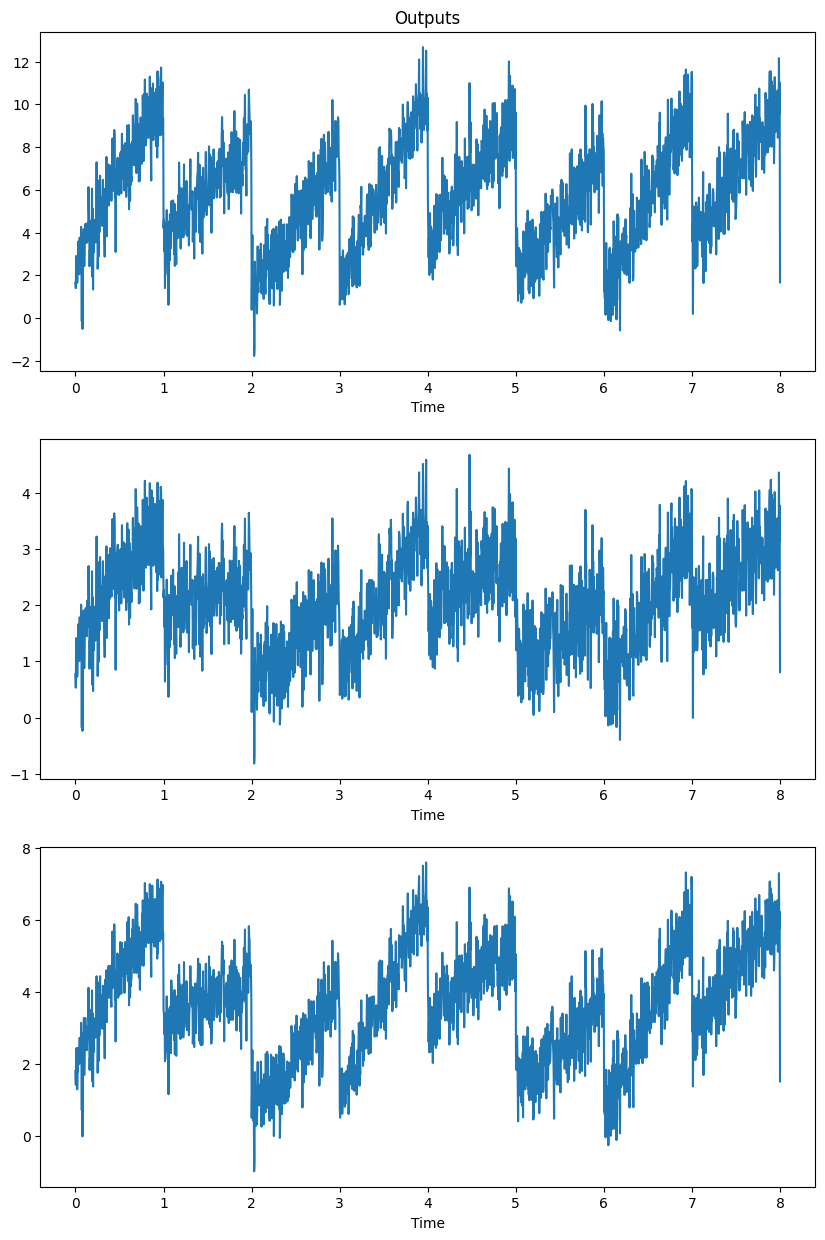

In [32]:

X=np.load('../solutions/noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs');


# PCA

If the total signal is a linear combination of 2 or 3 sources of signal / background, we could be able to separate them through PCA. We treat these time signals as similar to spectra: here "channels" are time bins, which register a quantity.

In [33]:
Xpca = X.T

n_comp = 3
pca = PCA(n_components=n_comp)
pca.fit(Xpca)
Y = pca.components_

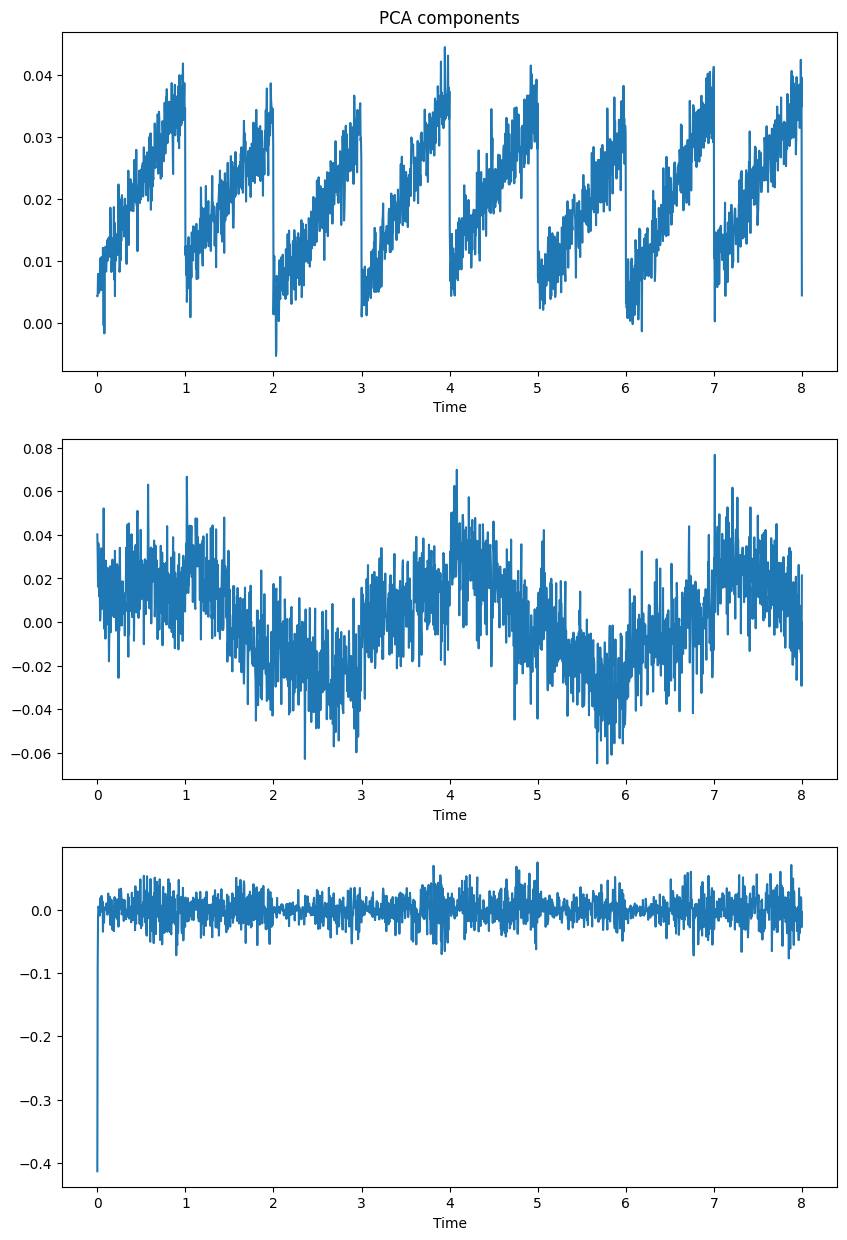

In [34]:
time = np.linspace(0, 8, 2000)

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,Y):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('PCA components');

PCA algorithm reconstructed 3 components, we can see that the second component is a noisy sinusoid

# ICA

In [35]:
np.random.seed(404)
ica = FastICA(n_components=3) 
ica.fit(X)

proj = ica.transform(X) 
comp = ica.components_ 

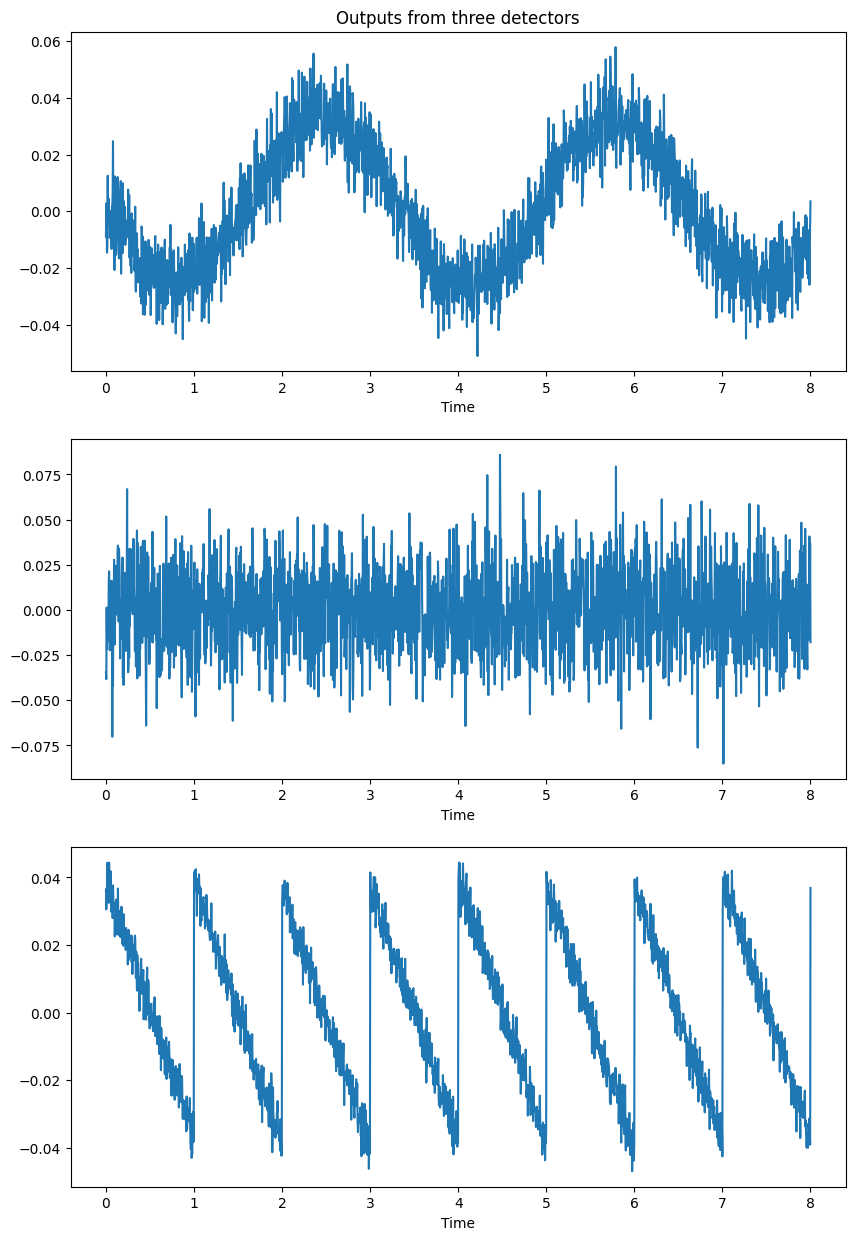

In [36]:

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(proj.shape[1],figsize=(10,15))

for ax,s in zip(axs,proj.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');

ICA performs a much better decomposition: we recognize the first component as a signal, the last two is noise.

## Fitting the signal - curve_fit

We will use the signal reconstructed by ICA and fit it with a sinusoid

In [37]:
from scipy.optimize import curve_fit

y = proj.T[0]
x = time

def sinusoid(t, A,T,phi):
    return  A*np.sin(2*np.pi/T * t + phi)

def sinusoid_b(t, A,T,phi,b):
    return  A*np.sin(2*np.pi/T * t + phi) + b

popt, pcov = curve_fit(sinusoid, x, y, p0=[0.04, 4, np.pi])
poptb, pcovb = curve_fit(sinusoid_b, x, y, p0=[0.04, 4, np.pi,0.01])

print(popt)

[0.02832241 3.31801654 3.18024377]


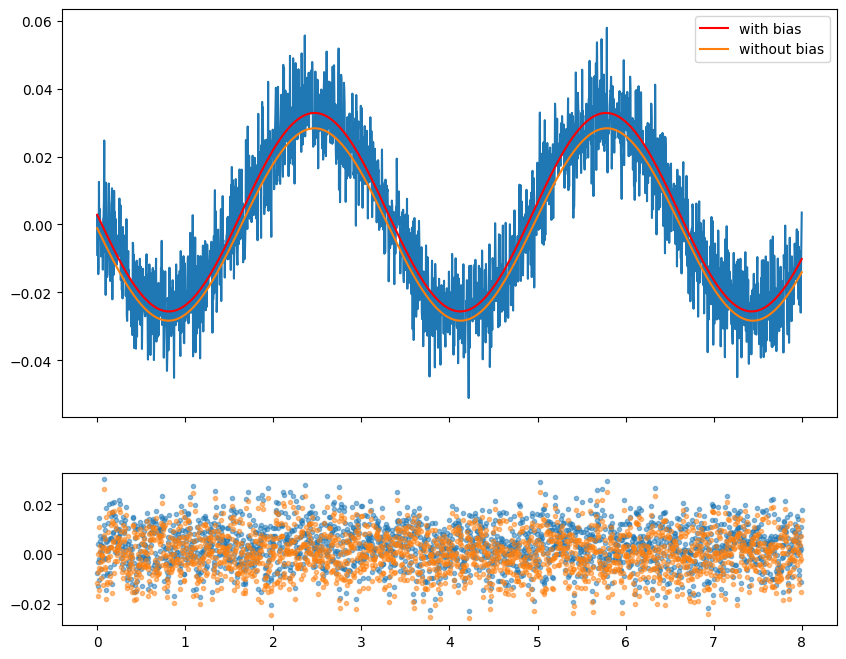

In [42]:
y_model_b = sinusoid_b(x, *poptb) 
y_model = sinusoid(x, *popt)

residuals = y - y_model
residuals_b =  y - y_model_b
mu = np.mean(residuals)
sigma = np.std(residuals)
mu_b = np.mean(residuals_b)
sigma_b = np.std(residuals_b)

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, figsize=(10,8), gridspec_kw={'height_ratios': [8, 3]})

ax = axs[0]
ax.plot(x,y)
ax.plot(x,y_model_b, label='with bias', c='red')
ax.plot(x,y_model, label='without bias')
ax.legend();

ax = axs[1]
ax.scatter(x,residuals, marker='.', alpha = 0.5)
ax.scatter(x,residuals_b, marker='.',  alpha = 0.5)



Let's plot the distributions of the residuals in both cases:

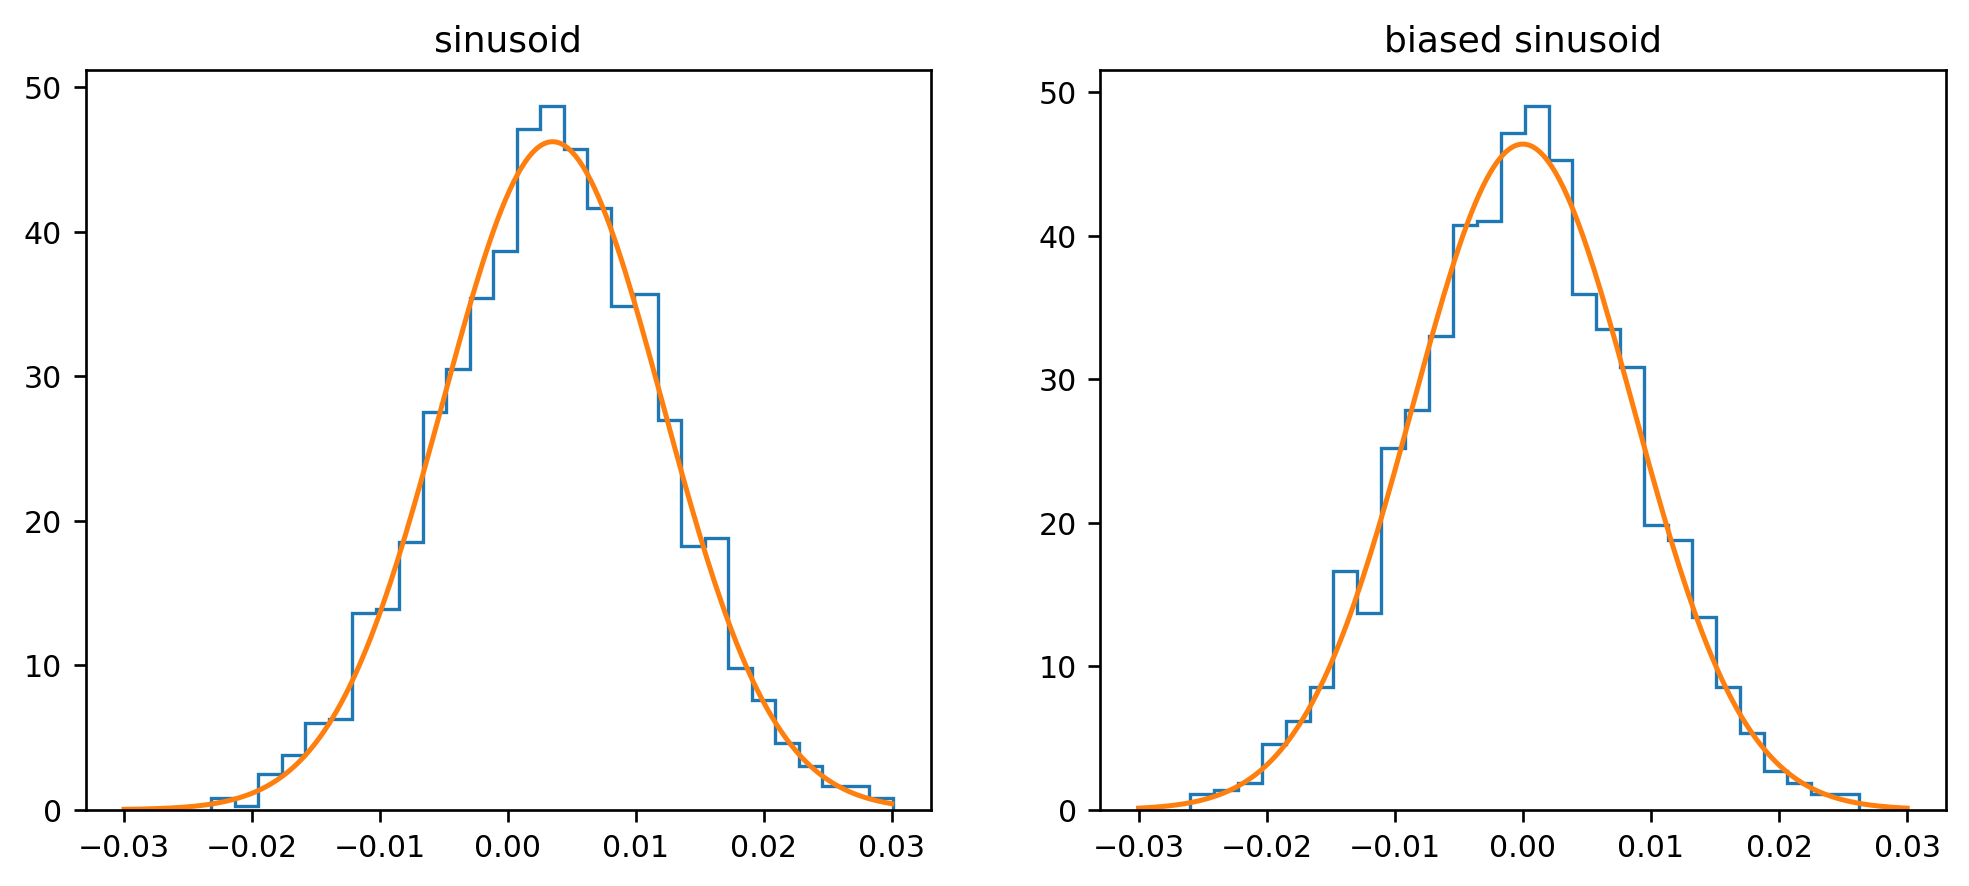

In [8]:
from scipy.stats import norm, normaltest

x_grid = np.linspace(-0.03, 0.03, 200)

#-------  Plt params  ----------------
%config InlineBackend.figure_format='retina'
plt.rc('figure', figsize=(10, 4), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig,ax = plt.subplots(1,2)

ax[0].hist(residuals, histtype='step', bins='auto', density=True)
ax[0].plot(x_grid,norm.pdf(x_grid, loc=mu, scale=sigma))
ax[0].set_title('sinusoid')

ax[1].hist(residuals_b, histtype='step', bins='auto', density=True)
ax[1].plot(x_grid,norm.pdf(x_grid, loc=mu_b, scale=sigma_b))
ax[1].set_title('biased sinusoid');

In [9]:
print(normaltest(residuals))
print(normaltest(residuals_b))


NormaltestResult(statistic=0.9578233517418377, pvalue=0.6194571952939079)
NormaltestResult(statistic=1.7423189604821716, pvalue=0.41846606471356684)


The noise is gaussian

## Fitting the signal - MCMC bayesian param. estimation

We use the sigma of the noise as error on the points.

In [44]:
def sin_model(t, theta):
    A, T, phi = theta
    return A * np.sin(2*np.pi/T * t + phi)

def log_likelihood(theta, t, y, model = sin_model): # Gaussian error = chi-squared likelihood
    y_model = model(t, theta)
    return - 0.5 * np.sum((y - y_model)**2 / sigma**2) # We do not have uncertainties on measurements, will use sigma computed as dispersion in noise

def log_prior(theta, limits): # uniform priors
    A, T, phi = theta
    A_min, A_max, T_min, T_max, phi_min, phi_max = limits
    if A_min < A < A_max and T_min < T < T_max and phi_min < phi < phi_max:
        return 0.0
    return - np.inf

def log_posterior(theta, limits, t, y, model = sin_model):
    return log_likelihood(theta, t, y, model = sin_model) + log_prior(theta, limits)

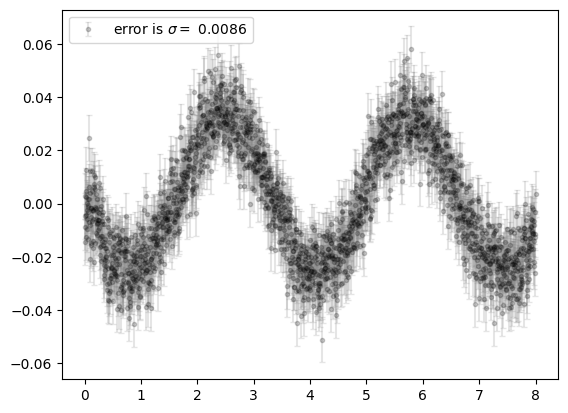

In [45]:
limits = [0.01, 0.06, 2, 4, 0, 2*np.pi]

plt.errorbar(time, y, yerr = sigma, fmt ='.k', ecolor = 'gray', capsize = 2, label = f'error is $\sigma =$ {sigma:.2}', alpha=0.2);
plt.legend(loc='upper left');

In [46]:
import emcee

# emcee params
ndim = 3 
nwalkers = 25
nsteps = int(3e4)

# initial parameter guess
theta_guess = popt + np.random.randn(nwalkers, ndim) * 0.001

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[limits, x, y, sin_model])
sampler.run_mcmc(theta_guess, nsteps);


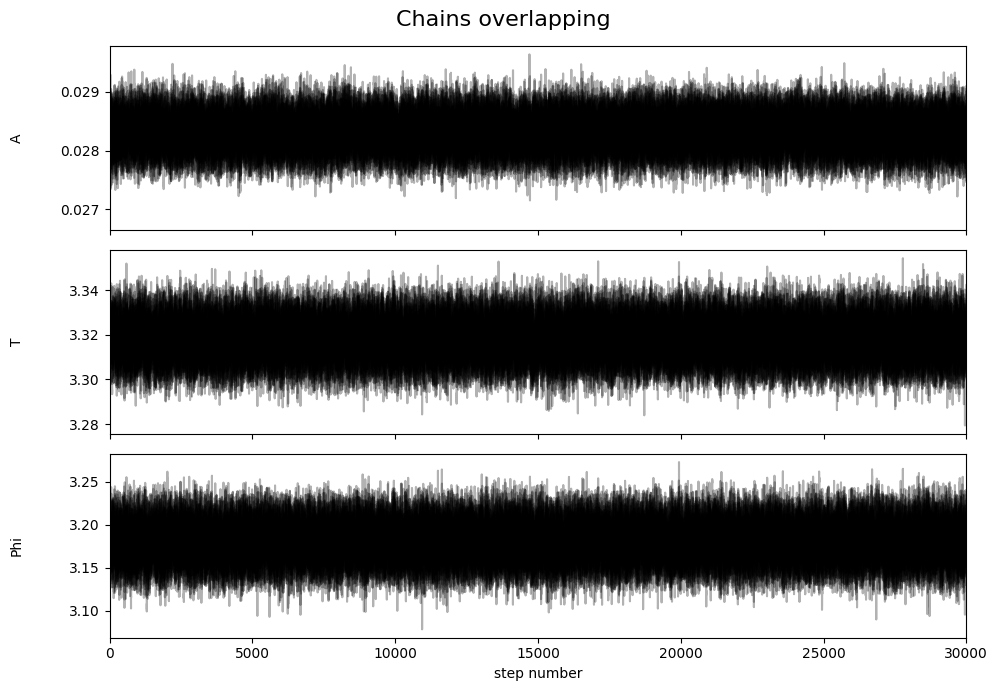

In [47]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()

labels = ["A","T","Phi"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
fig.suptitle('Chains overlapping', fontsize=16)
fig.tight_layout()

In [48]:
sampler.acceptance_fraction

array([0.64443333, 0.64876667, 0.65056667, 0.648     , 0.64623333,
       0.64463333, 0.64333333, 0.65006667, 0.6496    , 0.6488    ,
       0.64453333, 0.64536667, 0.64863333, 0.65313333, 0.64773333,
       0.64803333, 0.6508    , 0.63993333, 0.6462    , 0.65143333,
       0.64643333, 0.64636667, 0.64403333, 0.64003333, 0.6421    ])

In [49]:
# Remove burn-in and thin

corr_time = sampler.get_autocorr_time()
final_samples = np.asarray(sampler.get_chain(thin = int(max(corr_time)), discard = 4 * int(max(corr_time)), flat = True))
final_samples.shape

(18650, 3)

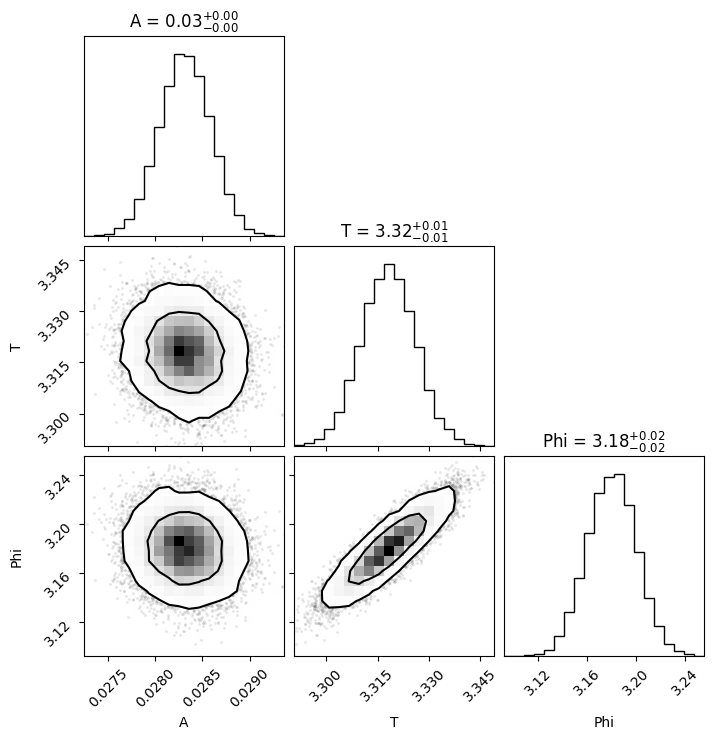

In [50]:
import corner

#corner plot
fig = corner.corner(
    final_samples, labels=labels, levels=[0.68,0.95], show_titles=True);

In [51]:
params = []

for i, label in enumerate(labels):
    low, med, sup = np.percentile(final_samples[:,i],[5,50,95]) 
    print(f'{label}\t=\t{med:.4f}\t+{sup-med:.4f}\t-{med-low:.4f}')
    params.append(med)

A	=	0.0283	+0.0004	-0.0004
T	=	3.3181	+0.0129	-0.0129
Phi	=	3.1808	+0.0325	-0.0333


In [52]:
from astroML.stats import sigmaG

sigma_g = sigmaG(final_samples[:,1])
tau = np.abs(popt[1] - params[1]) / np.sqrt(sigma_g**2 + sigma**2)

print(f'The two estimates of T are {tau:.4f} sigma apart')

The two estimates of T are 0.0102 sigma apart


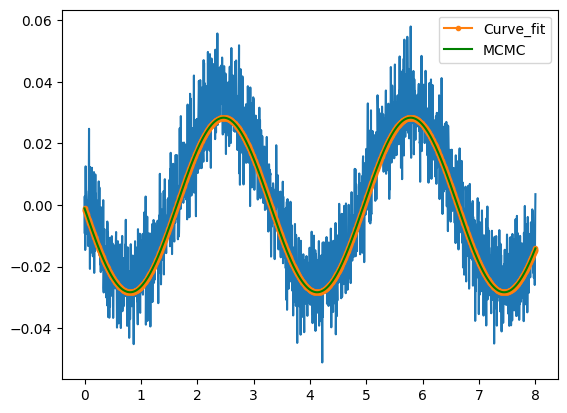

In [53]:
plt.plot(x,y)

y_model = sinusoid(x, *popt)

plt.plot(x,y_model, label='Curve_fit', marker='.',)
plt.plot(x, sinusoid(x, *params), label='MCMC', c='green')

plt.legend();